# Classification

### Prerequisites
- [Intro to PyTorch](https://github.com/AI-Core/Neural-Networks/blob/master/Intro%20to%20PyTorch.ipynb)

## Intro

Most tasks can be either defined as regression (predicting a continuous value e.g. house price) or classification (predicting a discrete value e.g. cat vs dog in images) problems.

The simplest form of a classification problem is binary classification, where an example either belongs to a class or doesn't and there is only one class. That is, every example has a lable which is either true or false.


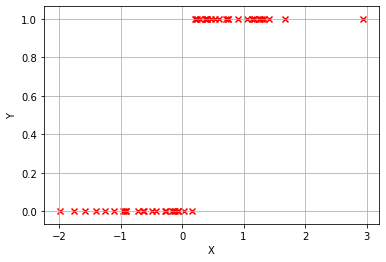

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def make_binary_data(m=50): 
    X = np.random.randn(m) #sample from a normal distribution
    X = np.array(sorted(X))
    Y = X > 0.2    # return binary vector with true where X above some threshold and false if below
    return X, Y #returns X (the input) and Y (labels)

def plot_data(X, Y):
    plt.figure()
    plt.scatter(X, Y, c='r', marker='x')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.show()
    
X, Y = make_binary_data()
plot_data(X, Y)

Previously, the output of our model could be any real number, negative or positive, unbounded in magnitude. 
In classification, we can interpret the model output as a confidence (probability) that the example belongs to a particular class. 
So for a classification task, any real numbered output value might not make sense.
Instead, to represent a class confidence we need to bound the output within the range 0-1.
We can do this by applying a **sigmoid** function to the output.

![](./images/sigmoid.jpg)

# derive the gradient of the sigmoid in simple form

Let's implement our sigmoid function in code, and let's also include a boolean argument which returns us the gradient if true.

In [40]:

def sigmoid(z, grad=False):
    if grad:
        return (1-sigmoid(z))*sigmoid(z)
    return 1 / (np.exp(-z) + 1)
    # return np.exp(z) / (1 + np.exp(z))


## Let's build our binary classifier model class

Stacking this transformation on the end of our usual linear transformation changes the model, and hence the gradient of the loss function.
We'll use the chain rule to compute the gradient of these composed linear and sigmoid functions.



In [75]:

class Classifier:
    def __init__(self, n_features):
        self.w = np.random.rand(n_features)
        self.b = np.random.rand()
    
    def __call__(self, x):
        x = self.w * x + self.b
        x = sigmoid(x)
        return x

    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b    

    def calc_deriv(self, X, y_hat, labels):
        m = len(Y) # m = number of examples
        diffs = y_hat - labels # calculate errors
        # dzdw = 2*np.array(np.sum(diffs*X) / m) # calculate derivative of loss with respect to weights
        # dzdb = 2*np.array(np.sum(diffs) / m) # calculate derivative of loss with respect to bias
        dzdb = 1
        dzdw = X

        dhdz = sigmoid(y_hat, grad=True)

        dhdw = dhdz*dzdw
        dhdb = dhdz*dzdb

        return dhdw, dhdb

# import torch
# import torch.nn.functional as F

# class Classifier(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear_layer = torch.nn.Linear(1, 1) #define the linear transformation
        
#     def forward(self, x):
#         x = self.linear_layer(x) #apply linear transformation
#         x = F.sigmoid(x) #add a sigmoid activation function to the end
#         return x


## The loss function for binary classification

Unlike in regression problems, how we measure the loss for a particular example in a classification problem depends on what the label is. That is, if the label is 1 (yes, it belongs to the positive class) then we want to penalise it more for having a prediction nearer to 0 (no, it belongs to the negative class), and vice versa.

### Binary cross entropy

![](./images/bce.jpg)
[Cross entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy)

Let's implement our binary cross entropy loss function

In [92]:
def BinaryCrossEntropyLoss(prediction, label, grad=False):
    if grad:
        if label == 0:
            return (1-label) / (1-prediction)
        else:
            return - (label / prediction)
    return - ( label*np.log(prediction) + (1 - label) * np.log(1 - prediction))

Now let's put all of this together to implement our training loop

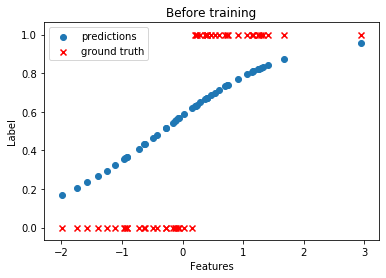

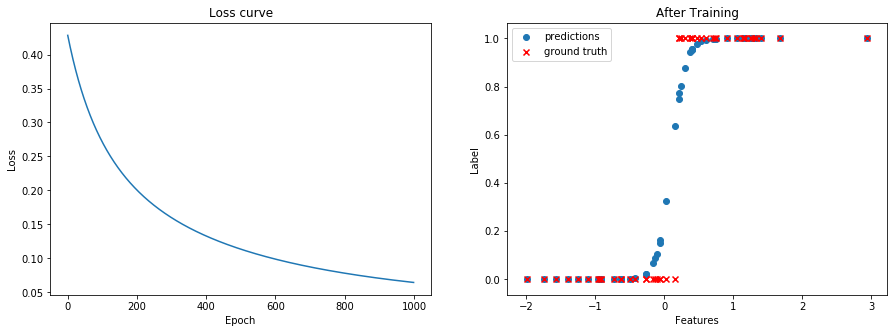

In [95]:
import matplotlib.pyplot as plt

learning_rate = 0.001

H = Classifier(n_features=1)

# PLOT OUR HYPOTHESIS BEFORE TRAINING
plt.figure()
plt.title('Before training')
plt.ylabel('Label')
plt.xlabel('Features')
plt.scatter(X, H(X), label='predictions')
plt.scatter(X, Y, c='r', marker='x', label='ground truth')
plt.legend()
plt.show()

epochs = 1000
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for x, y in zip(X, Y):
        prediction = H(x)
        loss = BinaryCrossEntropyLoss(prediction, y)
        epoch_losses.append(loss)
        dhdw, dhdb = H.calc_deriv(x, prediction, y)
        dLdh = BinaryCrossEntropyLoss(prediction, y, grad=True)
        dLdw = dLdh * dhdw
        dLdb = dLdh * dhdb
        new_w = H.w - learning_rate * dLdw
        new_b = H.b - learning_rate * dLdb
        H.update_params(new_w, new_b)
    losses.append(np.mean(epoch_losses))
        

# X, Y = torch.tensor(X).view(-1, 1), torch.tensor(Y).view(-1, 1) #convert data to tensors and add batch dimension
# Y = Y.double() #convert Y to a double

# H = Classifier().double() # initialise classifier and convert to double
# optimiser = torch.optim.Adam(H.parameters(), lr=0.01)# create optimiser

# # PLOT OUR HYPOTHESIS BEFORE TRAINING
# plt.figure()
# plt.title('Before training')
# plt.ylabel('Label')
# plt.xlabel('Features')
# plt.scatter(X, H(X).detach(), label='predictions')
# plt.scatter(X, Y, c='r', marker='x', label='ground truth')
# plt.legend()
# plt.show()

# epochs = 1000
# losses = []
# for epoch in range(epochs):
#     epoch_losses = []
#     for x, y in zip(X, Y):
#         prediction = H(x) # make prediction
#         loss = F.binary_cross_entropy(prediction, y) # compute loss
#         loss.backward() # calculate derivatives
#         optimiser.step() # make optimisation step
#         optimiser.zero_grad() # reset gradients
#         epoch_losses.append(loss)
#     losses.append(sum(epoch_losses)/len(epoch_losses))
        
# PLOT THE LOSS CURVE AND OUR HYPOTHESIS AFTER TRAINING
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax1.set_title('Loss curve')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.plot(losses)

ax2 = fig.add_subplot(122)
ax2.set_title('After Training')
ax2.set_ylabel('Label')
ax2.set_xlabel('Features')
ax2.scatter(X, H(X), label='predictions')
ax2.scatter(X, Y, c='r', marker='x', label='ground truth')
ax2.legend()
plt.show()

## Implementing classification in SKLearn

SkLearn is a Python library that has a load of tools for data science and modelling.
It contains model classes with simple APIs that allow us to train and test them easily without starting from scratch.

SkLearn is an industry-standard tool for traditional machine learning techniques like this.
We will use it throughout this chapter to show how to quickly implement any of the models that we cover.
However, we will see later that SkLearn is not capable of allowing us to imlement much more powerful [deep models].

Let's now use SkLearn to implement the same logistic regression algorithm as above, but with some significant abstraction.

Check out the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


torch.Size([50, 1]) torch.Size([50, 1])
/home/ice/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


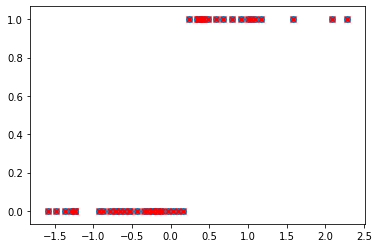

In [38]:
import sklearn

myLogisticModel = sklearn.linear_model.LogisticRegression()

print(X.shape, Y.shape)
Y_ = np.squeeze(Y) #remove empty dimensions
myLogisticModel.fit(X, Y_, solver='sag') # fit the model using SGD (a solver called sag in sklearn (Stochastic Average Gradient))
plt.scatter(X, myLogisticModel.predict(X)) # plot predictions
plt.scatter(X, Y, marker='x', c='r')
plt.show()


## Summary
- the labels for classification problems should be an integer representing the index of the class which that example belongs to
- binary cross entropy is a new differentiable loss function that can be optimised to solve classification problems
- binary classification can be implemented by having a single boolean integer label for each example, where 1 represents it being a member of that class and 0 represents it not being a member of that class

## Next steps:
- [Multiclass classification]